# PHYS20762 - Project 3 - Monte Carlo Method

Alexander Stansfield <br>
University of Manchester <br>
May 2022

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
import scipy.constants as const

plt.rcParams.update({'font.size': 20})
plt.style.use('default')

In [3]:
ABSORPTION_DICT = {'water': 0.6652,'lead': 0.158, 'graphite': 0.0045}
SCATTERING_DICT = {'water': 103.0,'lead': 11.221, 'graphite': 4.74}
DENSITY_DICT = {'water': 1.00e3,'lead': 11.35e3, 'graphite': 1.67e3}
MOLAR_MASS_DICT = {'water': 18.01528e-3,'lead': 207.2e-3, 'graphite': 12.011e-3}

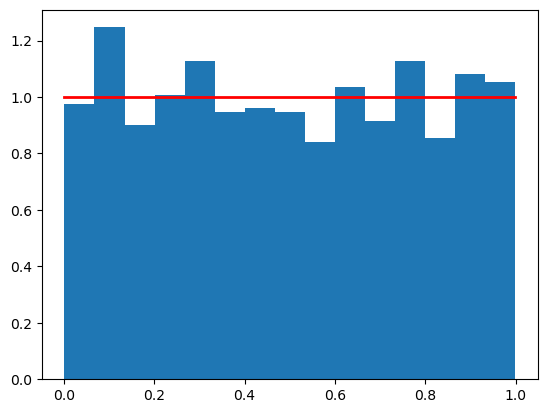

In [4]:
s  = np.random.uniform(0, 1, 1000)
count, bins, ignored = plt.hist(s, 15, density = True)
plt.plot(bins, np.ones_like(bins), linewidth = 2, color = 'red')
plt.show()

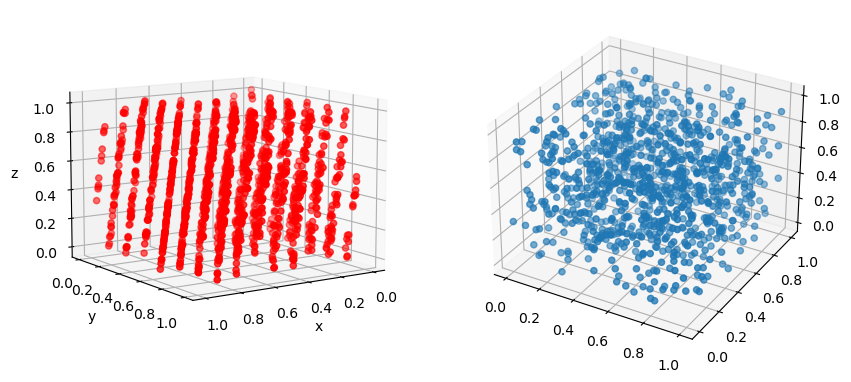

In [5]:
def randssp(p,q):
        
    try: x
    except NameError:
        m = pow(2, 31)
        a = pow(2, 16) + 3
        c = 0
        x = 123456789
    
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            x = np.mod(a*x + c, m)
            r[k, l] = x/m
    
    return r

k = randssp(3, 1500)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.scatter(k[0, :], k[1, :], k[2, :], color='r')

number_points = 1000
ax2.scatter(np.random.uniform(0, 1, number_points), np.random.uniform(0, 1, number_points), np.random.uniform(0, 1, number_points))

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

ax1.view_init(elev = 10, azim = 56)

plt.show()

In [6]:
def macroscopic_cross_section(density, molar_mass, cross_section):
    n = (density * const.N_A)/molar_mass
    Sigma = n*cross_section*10**(-28)
    return Sigma

def attenuation_calculation(Sigma_absorption, Sigma_scattering):
    mean_free_path = 1/(Sigma_absorption + Sigma_scattering)
    return mean_free_path

print(attenuation_calculation(macroscopic_cross_section(DENSITY_DICT['water'], MOLAR_MASS_DICT['water'], ABSORPTION_DICT['water']), 0))

0.4497155178303616


Fitted mean free path is 0.45 \pm 0.010 and mean free path coefficient put into random number generator is 0.45


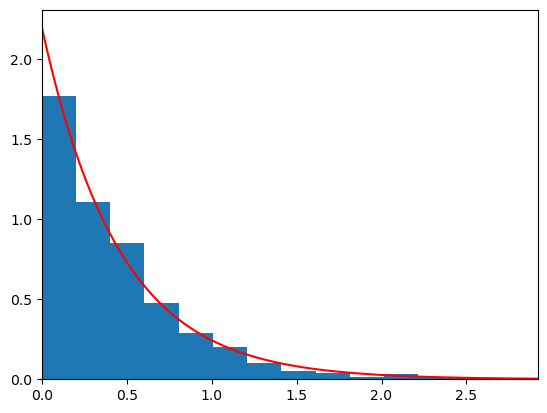

In [7]:
expected_mean_free_path = 0.45

def random_exponential(mean_free_path, count):
    return -mean_free_path*np.log(np.random.uniform(0, 1, count))

def exponential_function(data, coefficient):
    return 1/coefficient*np.e**(-data/coefficient)

def find_parameters(x, y):
    """
    Finds the best values for m_z, gamma_z and gamma_ee to have the
    lowest chi-square. Halts code if no optimised parameters could be
    found in the runtime allowed.

    Paramaters
    ----------
    data: 2D array of floats

    Returns
    -------
    3 floats
    """
    try:
        expected, uncertainty = curve_fit(exponential_function, x, y, p0 = 2) #, sigma=data[:, 2]
    except RuntimeError:
        print('Scipy.optimize.curve_fit was not able to find the best'
              ' parameters')

    return expected[0], math.sqrt(uncertainty[0, 0])

count, bins, ignored = plt.hist(random_exponential(expected_mean_free_path, number_points), 15, density = True)
bin_midpoints = 0.5*(bins[1:] + bins[:-1])
free_path, uncertainty = find_parameters(bin_midpoints, count)
plt.plot(np.linspace(0, np.max(bin_midpoints), 1000), exponential_function(np.linspace(0, np.max(bin_midpoints), 1000), free_path), color = 'red')
print('Fitted mean free path is {0:.2f} \pm {1:.3f} and mean free path coefficient put into random number generator is {2}'.format(free_path, uncertainty, expected_mean_free_path))

plt.xlim(0, np.max(bin_midpoints))
plt.show()

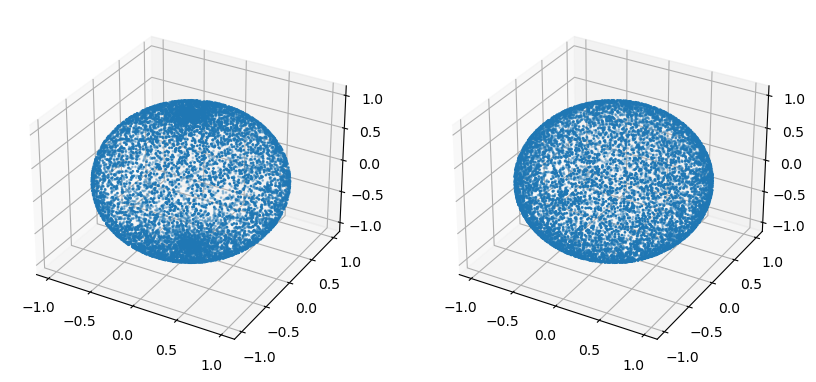

In [8]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

number_points = 10000

def poles_gather():
    theta = np.random.uniform(0, np.pi, number_points)
    phi = np.random.uniform(0, 2*np.pi, number_points)
    xdata = np.sin(theta)*np.cos(phi)
    ydata = np.sin(theta)*np.sin(phi)
    zdata = np.cos(theta)

    return xdata, ydata, zdata

def random_unit_sphere():
    theta = np.arccos(1 - 2*np.random.uniform(0, 1, number_points))
    phi = np.random.uniform(0, 2*np.pi, number_points)
    xdata = np.sin(theta)*np.cos(phi)
    ydata = np.sin(theta)*np.sin(phi)
    zdata = np.cos(theta)

    return xdata, ydata, zdata

ax1.scatter(*poles_gather(), s=1)
ax2.scatter(*random_unit_sphere(), s=1)
plt.show()

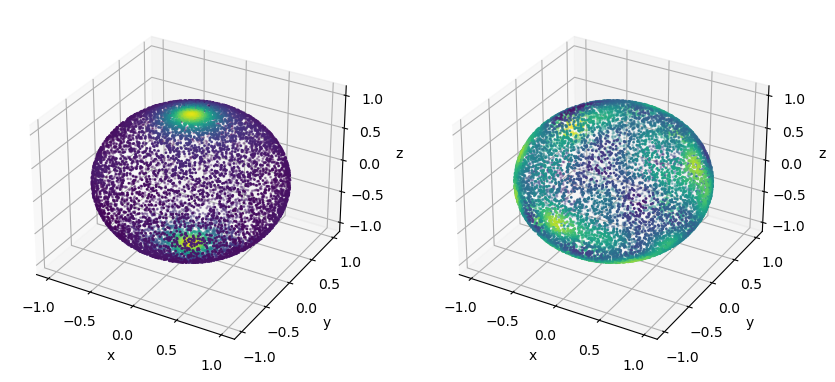

In [9]:
from scipy.stats import gaussian_kde

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

def normal_heat_map(axis, x_set, y_set, z_set):
    '''
    Function to generate a heat map from a given 3D datset.
    Uses a gaussian fit to determine the density of the
    values.
    
    Parameters
    ----------
    dataset : 2D array of floats
        Entire dataset for a randomly gnerated 3d region
        that follows a normal distribution.
    
    Returns
    -------
    None.
    
    '''
    density = gaussian_kde([x_set, y_set, z_set])([x_set, y_set, z_set])

    idx = density.argsort()
    x_set = x_set[idx]
    y_set = y_set[idx]
    z_set = z_set[idx]
    density = density[idx]

    axis.scatter(x_set, y_set, z_set, c=density, s=1)
    axis.set_xlabel('x')
    axis.set_ylabel('y')
    axis.set_zlabel('z')

normal_heat_map(ax1, *poles_gather())
normal_heat_map(ax2, *random_unit_sphere())

Fitted mean free path is 0.442 \pm 0.004 and mean free path coefficient put into random number generator is 0.45


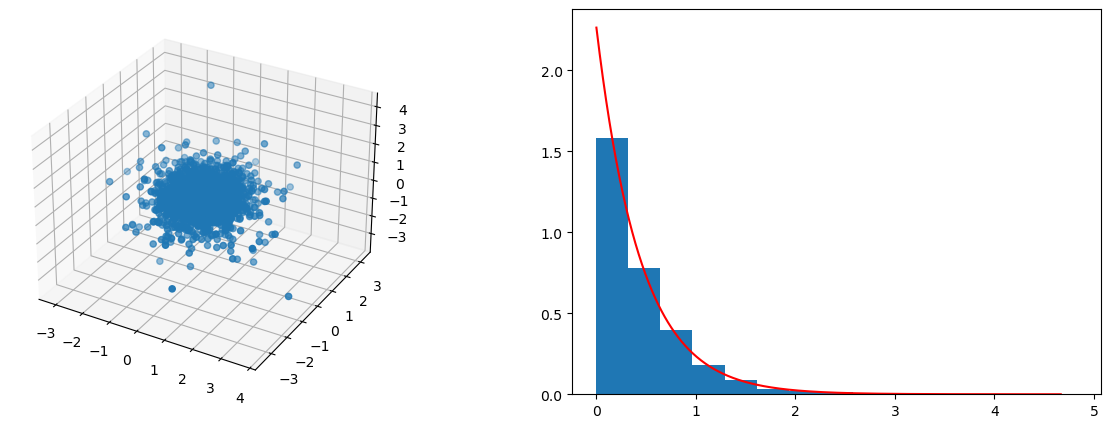

In [10]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

def isotropic_exponential_distribution(mean_free_path, quantity):
    theta = np.arccos(1 - 2*np.random.uniform(0, 1, quantity))
    phi = np.random.uniform(0, 2*np.pi, quantity)
    random_exponential_magnitude = random_exponential(mean_free_path, quantity)
    xdata = np.sin(theta)*np.cos(phi) * random_exponential_magnitude
    ydata = np.sin(theta)*np.sin(phi) * random_exponential_magnitude
    zdata = np.cos(theta) * random_exponential_magnitude

    return xdata, ydata, zdata

data = isotropic_exponential_distribution(expected_mean_free_path, number_points)
ax1.scatter(*data)

distance_data = np.sqrt(data[0]**2+data[1]**2+data[2]**2)
count, bins, ignored = ax2.hist(distance_data, 15, density = True)
bin_midpoints = 0.5*(bins[1:]+bins[:-1])
free_path, uncertainty = find_parameters(bin_midpoints, count)
ax2.plot(np.linspace(0, np.max(bin_midpoints), 1000), exponential_function(np.linspace(0, np.max(bin_midpoints), 1000), free_path), color = 'red')
print('Fitted mean free path is {0:.3f} \pm {1:.3f} and mean free path coefficient put into random number generator is {2}'.format(free_path, uncertainty, expected_mean_free_path))

plt.show()
    

# Complete Simulation of Absorption

For each material, we need to determine the macroscopic absorption and scattering cross sections, and the resultant total mean free path $\lambda$. The macroscopic cross-section of an event, $\Sigma$, is:

\begin{equation}
\Sigma = n\sigma
\end{equation}

where $n = \frac{\rho N_A}{M}$ and $\sigma$ is the microscopic cross-section of the event. Using the values below for the properties of the materials, we can use equation (1) to find the macroscopic cross-section.

\begin{array}{c|ccc}
    & \text{Water} & \text{Lead} & \text{Graphite}\\ \hline
   \text{Absorption}, \sigma_a (barn) & 0.6652 & 0.158 & 0.0045\\
   \text{Scattering}, \sigma_s (barn) & 103.0 & 11.221 & 4.74\\
   \text{Density}, \rho (g/cm^3) & 1.00 & 11.35 & 1.67
\end{array}

where the unit convesions to base units is $1\text{barn} = 10^{-28}m^2$ and $1g/cm^3 = 10^{3}kg/m^3$. The total macroscopic cross-section is $\Sigma_T = \Sigma_a + \Sigma_s$ where $\Sigma_a$ is the macroscopic cross-section for absorption events and $\Sigma_s$ is the macroscopic cross-section for scattering events. To find the total mean free path, $\lambda_T$ we use:

The mean free path, average distance a particle will travel before encountering one of the events, is:

\begin{equation}
\lambda = \frac{1}{\Sigma_T} = \frac{1}{\Sigma_a+\Sigma_s}
\end{equation}

Thus the absorption and scattering cross sections, and the resultant total mean free path are found to be:


In [11]:
materials = ['water', 'lead', 'graphite']
values = []

for material in materials:
    sigma_a =  macroscopic_cross_section(DENSITY_DICT[material], MOLAR_MASS_DICT[material], ABSORPTION_DICT[material])
    values.append(sigma_a)
    sigma_s =  macroscopic_cross_section(DENSITY_DICT[material], MOLAR_MASS_DICT[material], SCATTERING_DICT[material])
    values.append(sigma_s)
    print('The macroscopic cross-section of absorption and scattering for {0} is: {1:.3f}, {2:.3f}. The total mean free path is {3:.3f}\
    '.format(material, sigma_a, sigma_s, attenuation_calculation(sigma_a, sigma_s)))

The macroscopic cross-section of absorption and scattering for water is: 2.224, 344.308. The total mean free path is 0.003    
The macroscopic cross-section of absorption and scattering for lead is: 0.521, 37.016. The total mean free path is 0.027    
The macroscopic cross-section of absorption and scattering for graphite is: 0.038, 39.689. The total mean free path is 0.025    


For each neutron travelling through the material, we will need to simulate it travelling a distance based off of the exponential probaility distrubution function defined above. After each step, we then generate a random number between 0 and 1. If the random number is less than probaility of absorption, $p_a = \frac{\Sigma_a}{\Sigma_T}$, then the neutron is aborbed, otherwise it is scattered.

Each neutron starts from one surface of the slab (take as x = 0), and then performs a random walk where each step is drawn from the distribution $e^{-\frac{x}{\lambda_T}}$, as above. After each step, you will need to check whether the neutron is absorbed in the slab, has escaped from the slab (x < 0 or x > T), or continues onto a following step. (Hint: Use a while loop, generating the entire set of steps and their locations; a flag variable is_absorbed can be set to 1 to tell the while loop to terminate, whilst another variable i can be used to keep track of how many steps have been taken. The while loop should be continued if all of these conditions are true: x > 0 or x<T then is_absorbed == 0.

In [12]:
class neutron():
    def __init__(self, sigma_a: float, sigma_s: float, mean_free_path: float, thickness: float):
        self.is_absorbed = False
        self.is_backscattered = False
        self.is_transmitted = False
        self.sigma_a = sigma_a
        self.sigma_s = sigma_s
        self.mean_free_path = mean_free_path
        self.thickness = thickness
        self.x_position = np.abs(isotropic_exponential_distribution(self.mean_free_path, 1)[0])
        
    def timestep(self):
        random_number = np.random.uniform(0, 1, 1)
        if random_number < 0.00642:
            self.is_absorbed = True
        self.x_position += isotropic_exponential_distribution(self.mean_free_path, 1)[0]
        if self.x_position < 0:
            self.is_backscattered = True
        elif self.x_position > self.thickness:
            self.is_transmitted = True
#WATER
absorption_cross_section = values[0]
scattering_cross_section = values[1]
free_path = 1/(absorption_cross_section + scattering_cross_section)
slab_thickness = 0.1

number_neutrons = 10000
neutrons = [neutron(absorption_cross_section, scattering_cross_section, free_path, slab_thickness) for _ in range(number_neutrons)]

number_absorbed = 0
number_backscattered = 0
number_transmitted = 0

while len(neutrons) > 0:
    for index, particle in enumerate(neutrons):
        particle.timestep()
        if particle.is_absorbed == True:
            number_absorbed += 1
            neutrons.pop(index)
        elif particle.is_backscattered == True:
            number_backscattered += 1
            neutrons.pop(index)
        elif particle.is_transmitted == True:
            number_transmitted += 1
            neutrons.pop(index)

print(number_absorbed, number_backscattered, number_transmitted)

1512 8463 25
